# 01 Server Rackmount Forecast

Quick validation notebook for the `data/processed/synosales_cleaned.parquet` output. Once the structure is confirmed, lift the aggregation logic into a production module under `src/` as part of the export-to-module plan.

In [13]:
import numpy as np
import os
import sys
from pathlib import Path
import pandas as pd
import warnings
import sklearn
import itertools
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

In [14]:
os.getcwd()

'/Volumes/docker/syno_bi/repo/notebook'

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from xgboost import XGBRegressor


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [16]:
repo = Path("/Volumes/docker/syno_bi/repo")
df = pd.read_parquet(repo / "data/processed/synosales_cleaned.parquet")

suite_NAS = df[df["source_sheet"].isin(["2023", "2024"])]
suite_C2 = df[df["source_sheet"].isin(["2023-C2", "2024-C2"])]

In [26]:
suite_NAS_subset = suite_NAS[["PI", "Customer", "ItemCode", "Product", "Quantity", "usd_adjusted_price", "usd_adjusted_total", "InvDate", "Country", "Type", "sub_cat", "Year", "Region", "source_sheet"]]
suite_C2_subset = suite_C2[["PI", "Customer", "ItemCode", "Product", "Quantity", "usd_adjusted_price", "usd_adjusted_total", "InvDate", "Country", "Type", "sub_cat", "Year", "Region", "source_sheet"]]

In [27]:
suite_NAS_subset["InvDate"] = pd.to_datetime(suite_NAS_subset["InvDate"])
suite_NAS_subset["usd_adjusted_total"] = suite_NAS_subset["usd_adjusted_total"].astype(float)

In [28]:
suite_NAS_clean = suite_NAS_subset[suite_NAS_subset["sub_cat"].fillna("").str.startswith("SVR-RM")].copy()

In [29]:
monthly_rev = (
    suite_NAS_clean.groupby(pd.Grouper(key="InvDate", freq="M"))["usd_adjusted_total"]
    .sum()
    .reset_index()
)

/var/folders/dt/7vnpb4hn01d19x7dfz27zs5h0000gn/T/ipykernel_12255/2786123579.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  suite_NAS_clean.groupby(pd.Grouper(key="InvDate", freq="M"))["usd_adjusted_total"]


Baseline

In [30]:
train = monthly_rev[monthly_rev["InvDate"] <= "2024-09-30"]
test  = monthly_rev[monthly_rev["InvDate"] >  "2024-09-30"]

In [31]:

model = SARIMAX(train["usd_adjusted_total"], order=(1,1,1), seasonal_order=(1,1,1,12))
fit = model.fit()
forecast = fit.forecast(steps=3)

/Users/tonychu/Git Repository/syno_prediction/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/tonychu/Git Repository/syno_prediction/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [32]:
forecast = fit.get_forecast(steps=3)
pred_mean = forecast.predicted_mean
conf_int = forecast.conf_int(alpha=0.05)

In [38]:
conf_int

,lower usd_adjusted_total,upper usd_adjusted_total
1,12122.785035,16042.714965
2,11310.940965,16854.559035
3,10687.991100,17477.508900


In [39]:
lower_col, upper_col = conf_int.columns

forecast_index = pd.to_datetime(pred_mean.index)

sarimax_forecast_df = pd.DataFrame(
    {
        "forecast": pred_mean.values,
        "forecast_lower": conf_int.iloc[:, 0].values,
        "forecast_upper": conf_int.iloc[:, 1].values,
    },
    index=forecast_index,
)
sarimax_forecast_df.index.name = "forecast_month"

ValueError: x and y must have same first dimension, but have shapes (0,) and (3,)

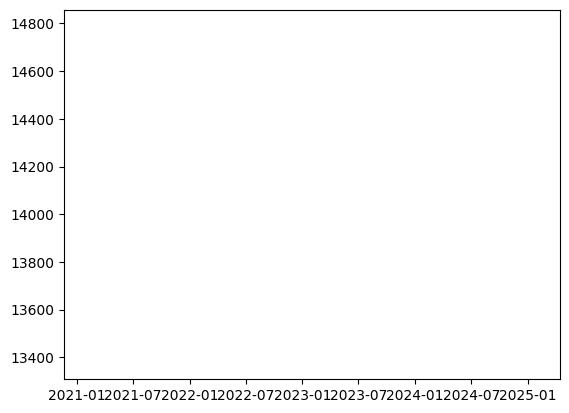

In [40]:
plt.plot(train["InvDate"], train["usd_adjusted_total"], label="Train")
plt.plot(test["InvDate"], test["usd_adjusted_total"], label="Actual")
forecast_dates = pd.date_range(train["InvDate"].max() + pd.offsets.MonthEnd(1), periods=len(pred_mean), freq="M")
plt.plot(forecast_dates, pred_mean.values, label="Forecast", linestyle="--")
plt.fill_between(forecast_dates, conf_int.iloc[:, 0].values, conf_int.iloc[:, 1].values, alpha=0.2, label="Confidence Interval")
plt.legend()
plt.title("NAS Revenue Forecast (SARIMAX)")
plt.show()

In [11]:
mape = np.mean(
    np.abs(test["usd_adjusted_total"].values - pred_mean.values)
    / test["usd_adjusted_total"].values
) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 6.98%
